# Classification problem on the Titanic data set

## First some imports

In [5]:
import numpy as np
import pandas as pd
import re

# plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# For missing numbers (just for convenience)
import missingno as msno

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

# All models used here
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

## Read in the data

In [7]:
df_train = pd.read_csv("data/train.csv")
df_test  = pd.read_csv("data/test.csv")

df_train.drop(columns=["PassengerId"], inplace=True)
PassengerId = df_test["PassengerId"]
df_test.drop(columns=["PassengerId"], inplace=True)

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
df_test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


<AxesSubplot: >

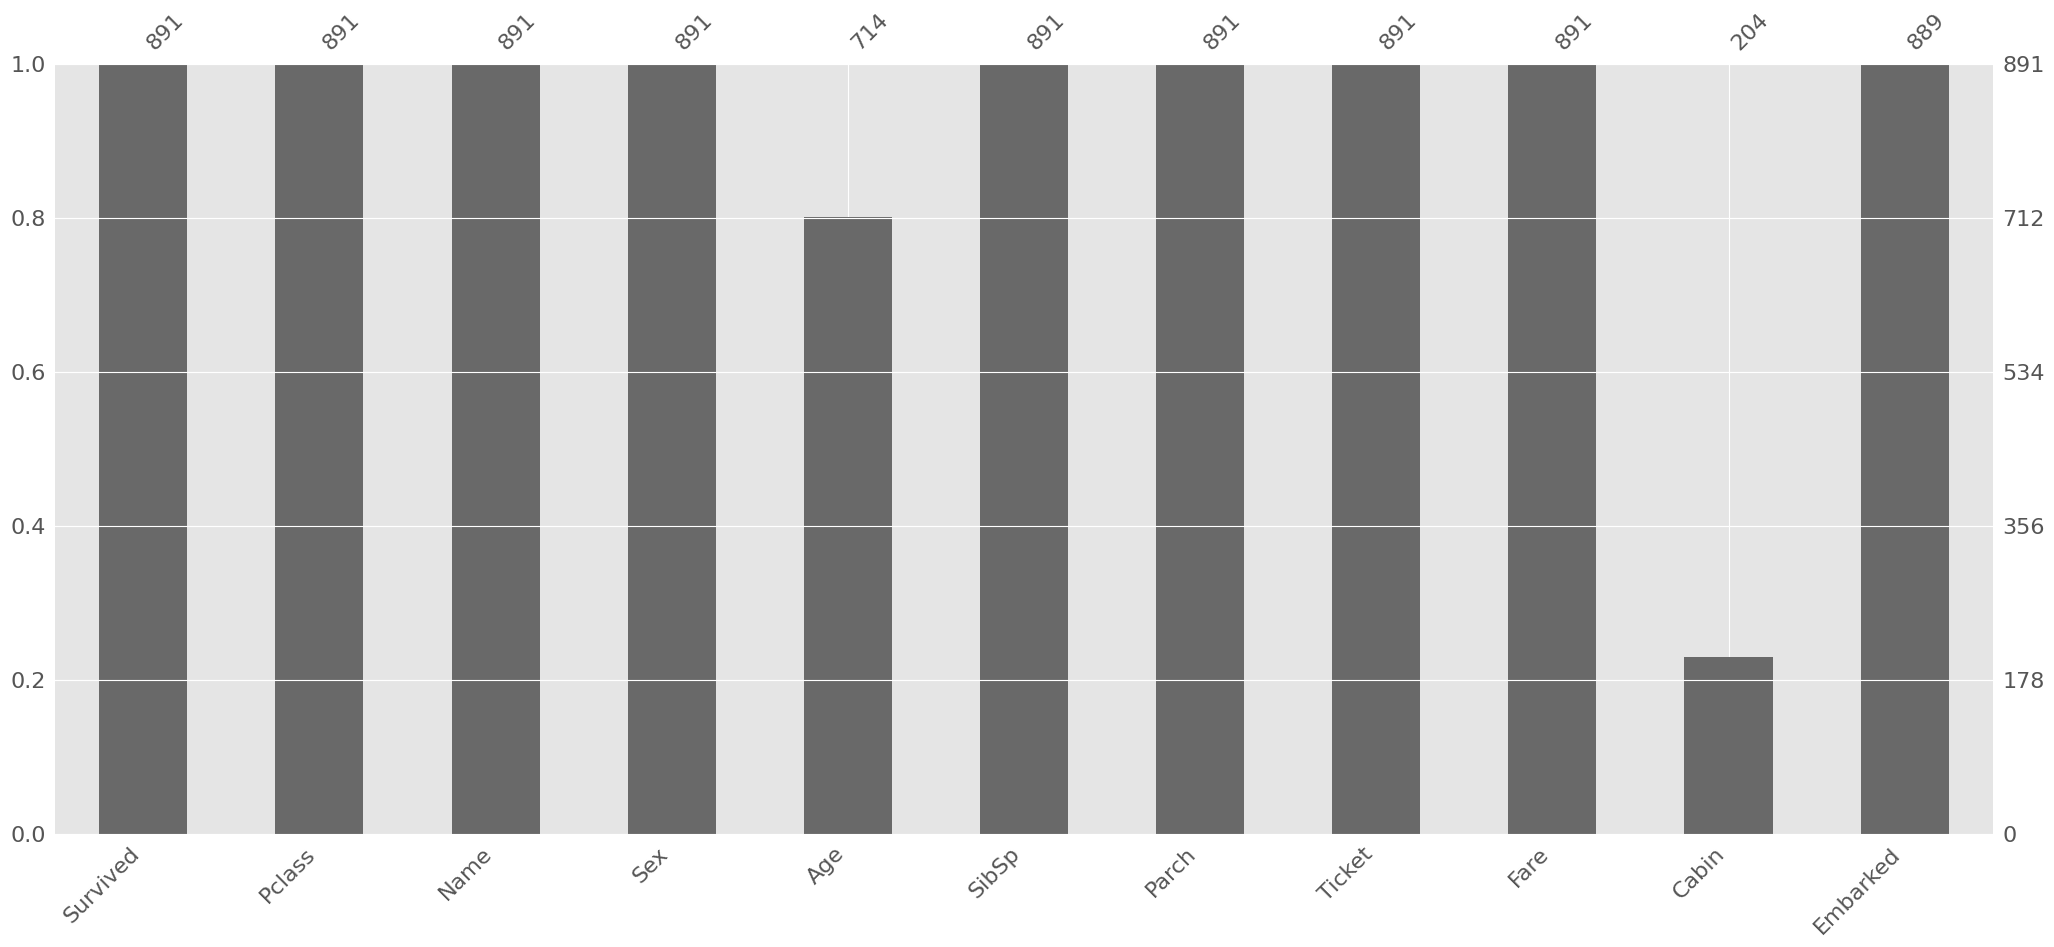

In [10]:
msno.bar(df_train)

<AxesSubplot: >

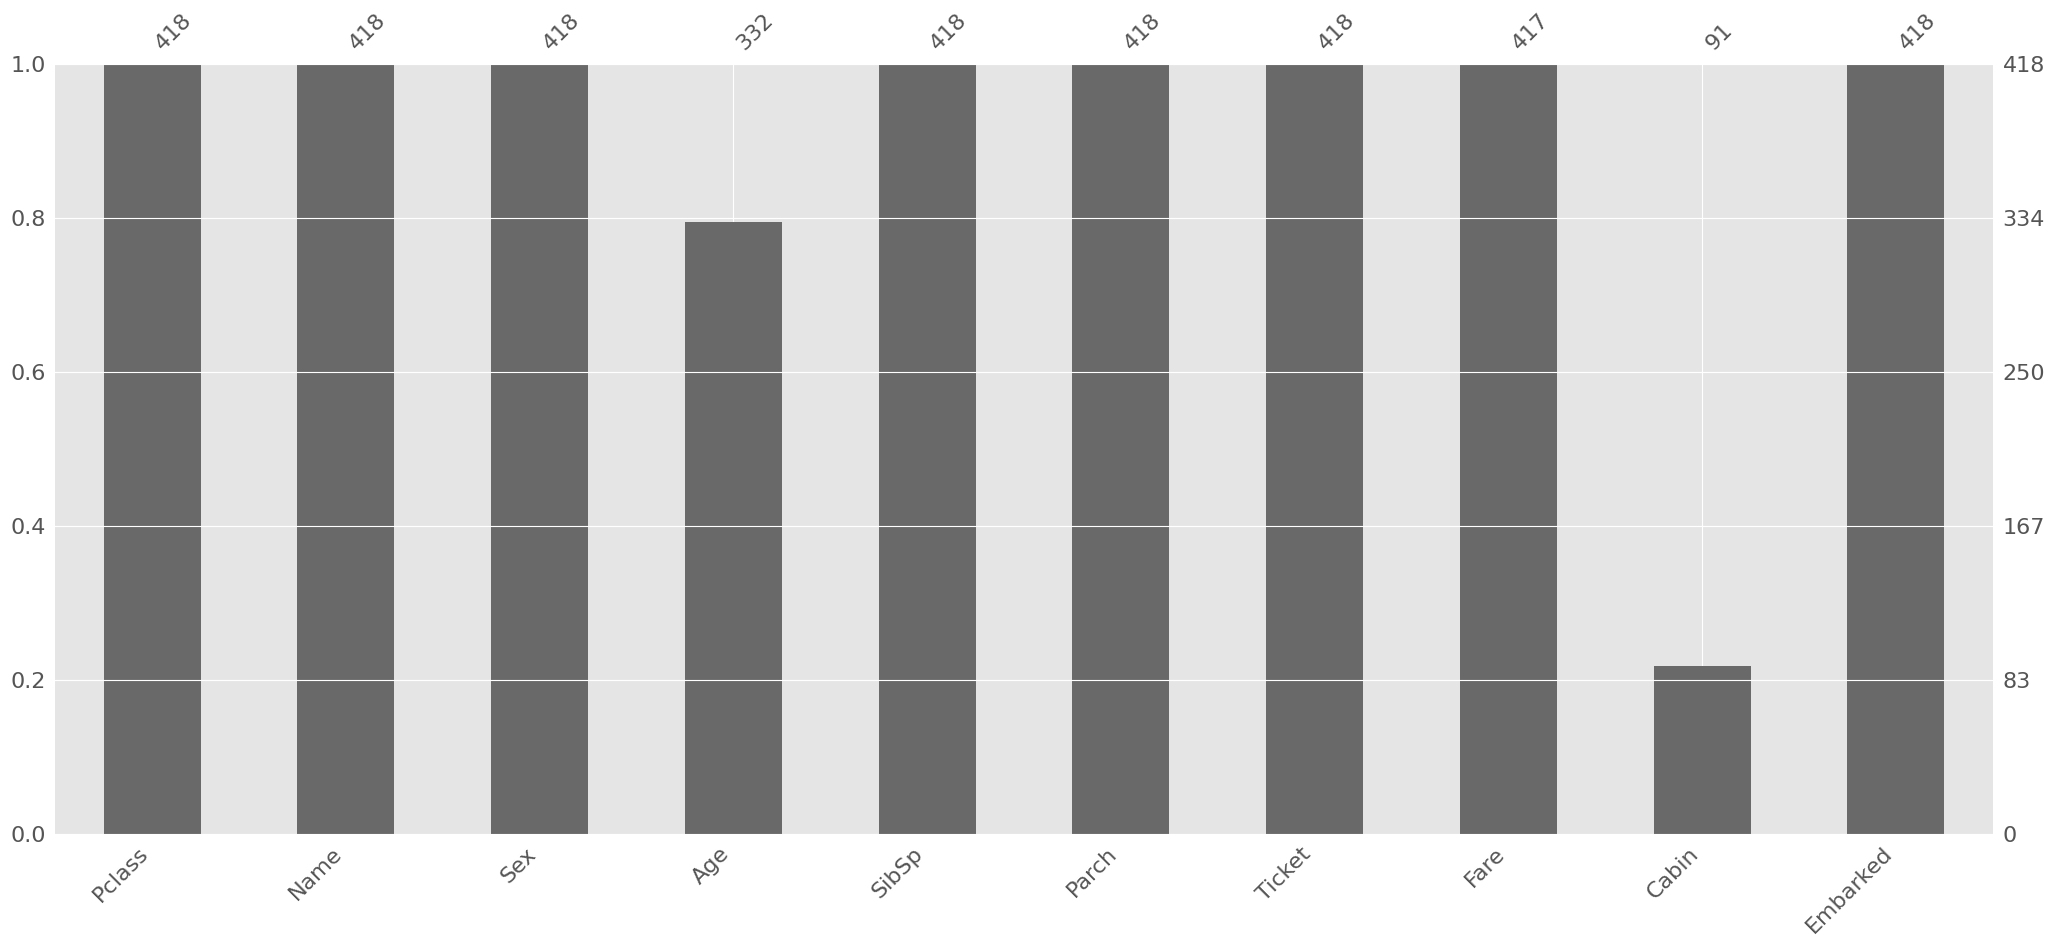

In [11]:
msno.bar(df_test)

## Plot the data

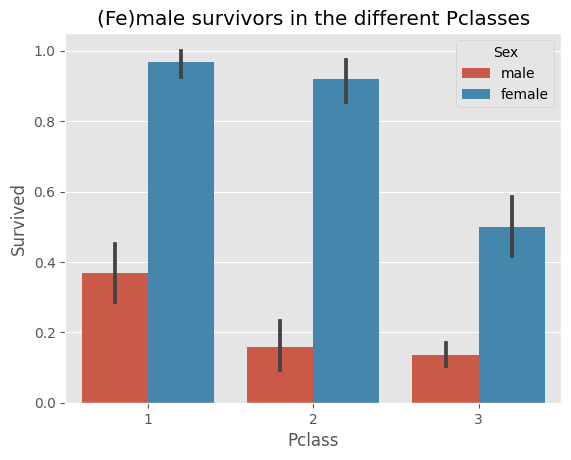

In [12]:
sns.barplot(x='Pclass',y='Survived', hue='Sex', data=df_train)
plt.title("(Fe)male survivors in the different Pclasses")
plt.show()
plt.close()

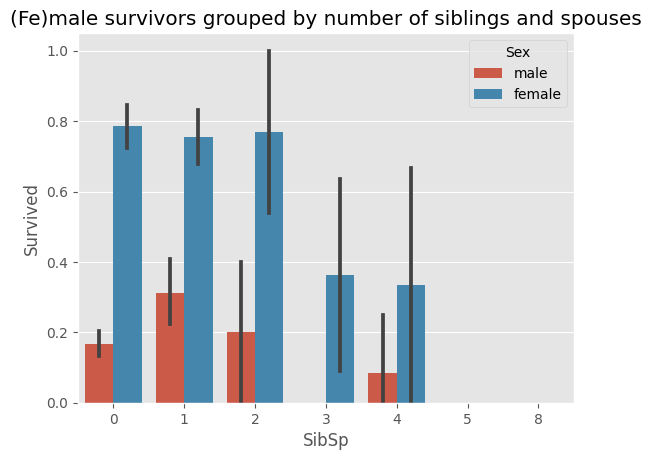

In [13]:
sns.barplot(x='SibSp',y='Survived', hue='Sex', data=df_train)
plt.title("(Fe)male survivors grouped by number of siblings and spouses")
plt.show()
plt.close()

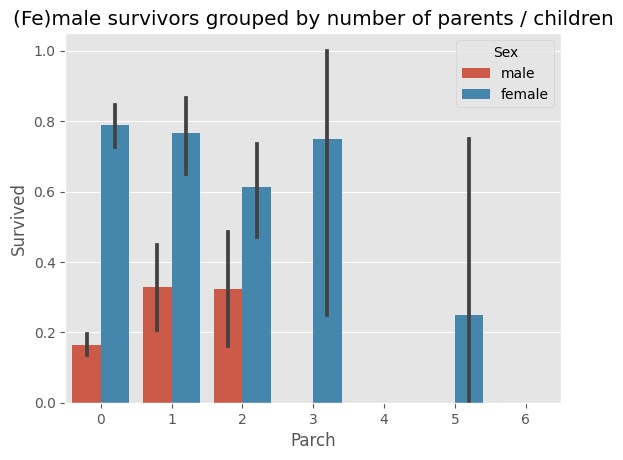

In [14]:
sns.barplot(x='Parch',y='Survived', hue='Sex', data=df_train)
plt.title("(Fe)male survivors grouped by number of parents / children")
plt.show()
plt.close()

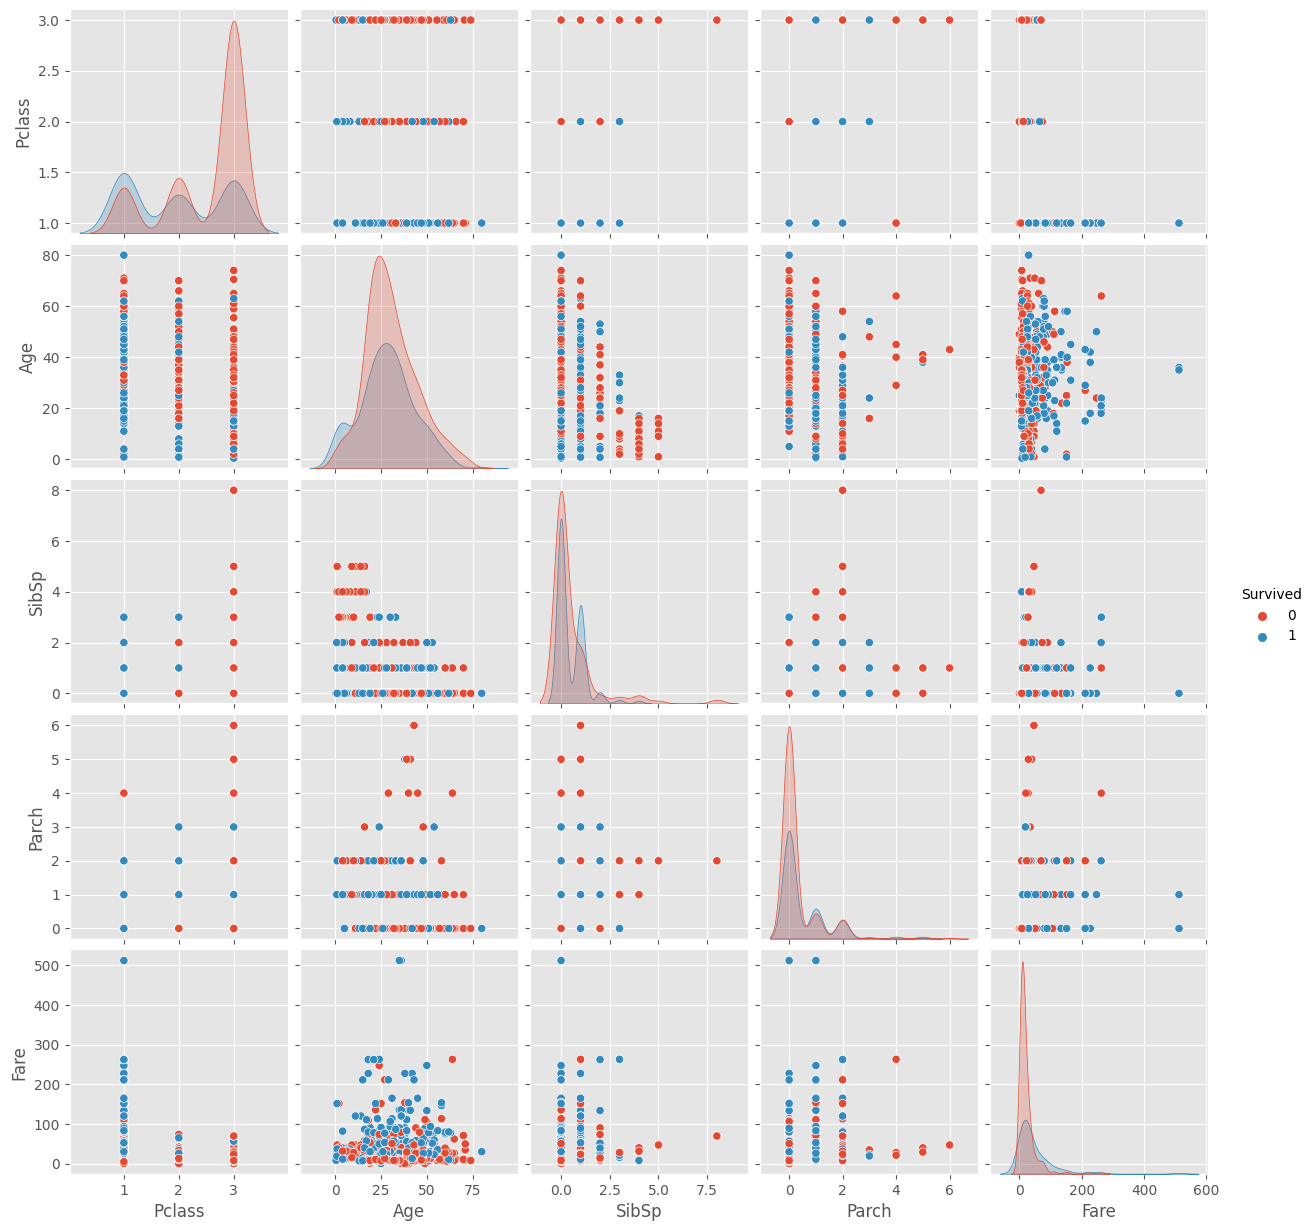

In [15]:
sns.pairplot(df_train, hue='Survived')

<AxesSubplot: >

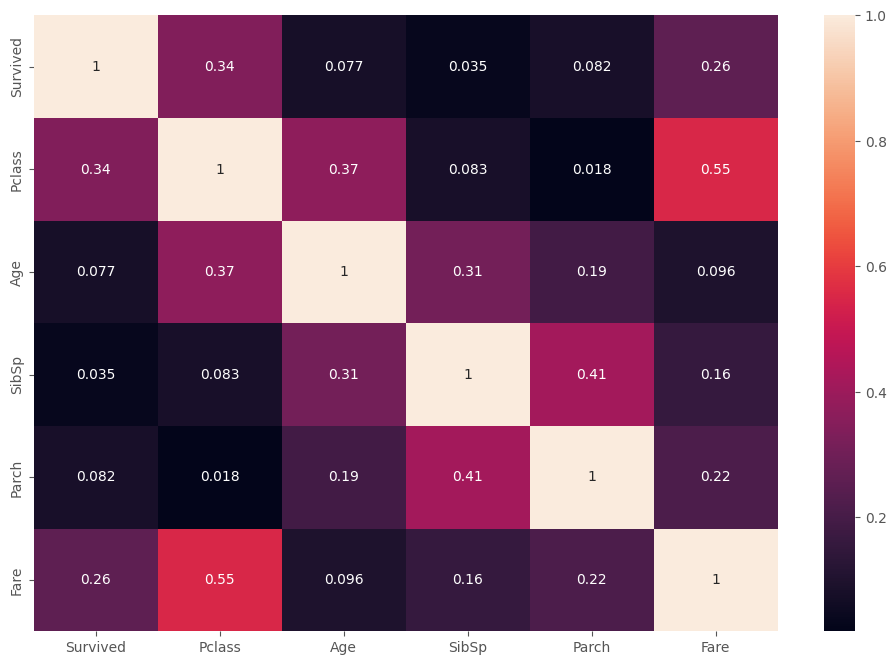

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train.corr(numeric_only = True).abs(), annot=True)

## Observations 
 * Cabin has a lot of missing values (drop it). 
 * Name column contains the title. Extract it.
 * Embarkation is the port where the passengers boarded C=Cherbourg (168), Q=Queenstown (77), S=Southampton (644), there are only two values missing. Just use "S" for the two missing values.
 * Some Age values are missing. Try the IterativeImputer (careful it is experimental). The iterative Imputer is a regression and finds the best fitting values.
 * I don't even want to know how the Ticketnumber logic is. I hope it is random and has no information. I will just drop it here.
 * In the name column only the title can be from importance. Try to extract it this feature and drop the name.
 * The test data set has one Fare value missing. 

## Feature Engineering

Combine df_train, df_test for feature engineering

In [17]:
df_combi = pd.concat([df_train, df_test], axis=0)
df_combi.shape

(1309, 11)

### Extract the title of the name column. 

Notice that the title comes always after the first comma and ends with a dot.

In [18]:
df_combi['Title'] = df_combi['Name'].str.extract('([A-Za-z]+)\.', expand=False)

<AxesSubplot: xlabel='Title', ylabel='count'>

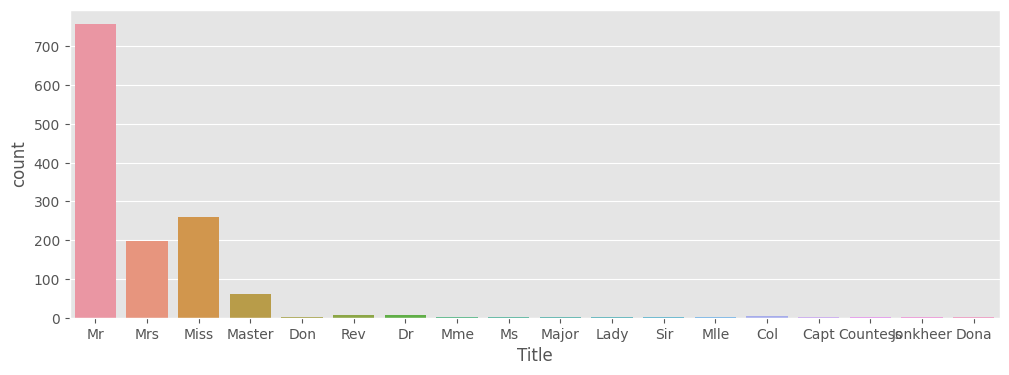

In [19]:
plt.figure(figsize=(12,4))
sns.countplot(x='Title', data=df_combi)

Most of the titles are rare. Therefore rename some of them or call them "noble". We have the following:

* Mlle = Mademoiselle is equivalent to "Miss"
* Mme = Madame is equivalent to "Mrs"
* Ms = is only one which is 28 years old. It shouldnt matter. Is now a "Mrs"

The rest will be renamed to "noble".

In [20]:
renamer = {"Miss" : "Mlle",
           "Mrs": ["Mme", "Ms"],
           "noble": ["Don","Rev","Dr","Lady","Sir","Col","Countess","Mme","Major","Capt","Jonkheer","Dona"]}

for k in renamer:
    df_combi["Title"] = df_combi["Title"].replace(renamer[k],k)

In [21]:
df_combi["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'noble'], dtype=object)

### Imputing and One-Hot-Encoding

Fill the one missing Fare value in the Test data.

In [22]:
df_combi[df_combi["Fare"].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
152,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


In [23]:
print(df_train["Fare"].mean())
print(df_train[df_train["Pclass"]==3]["Fare"].mean())
fare_value = df_train[df_train["Pclass"]==3]["Fare"].mean()

32.204207968574636
13.675550101832993


In [24]:
df_combi["Fare"] = df_combi["Fare"].fillna(fare_value)

In [25]:
df_combi.loc[df_combi["Embarked"].isna(), "Embarked"] = "S"

In [26]:
df_combi['Sex'] = df_combi['Sex'].map({'male': 0, 'female': 1})
df_combi = pd.get_dummies(df_combi, columns=['Embarked', 'Title'], drop_first=True)

In [27]:
df_combi.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_noble
0,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,1,0,0
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,1,0
2,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,0,0,0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,0,0,1,0
4,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,0,1,0,0


In [28]:
df_combi['FamilySize'] = df_combi['SibSp'] + df_combi['Parch']

<AxesSubplot: >

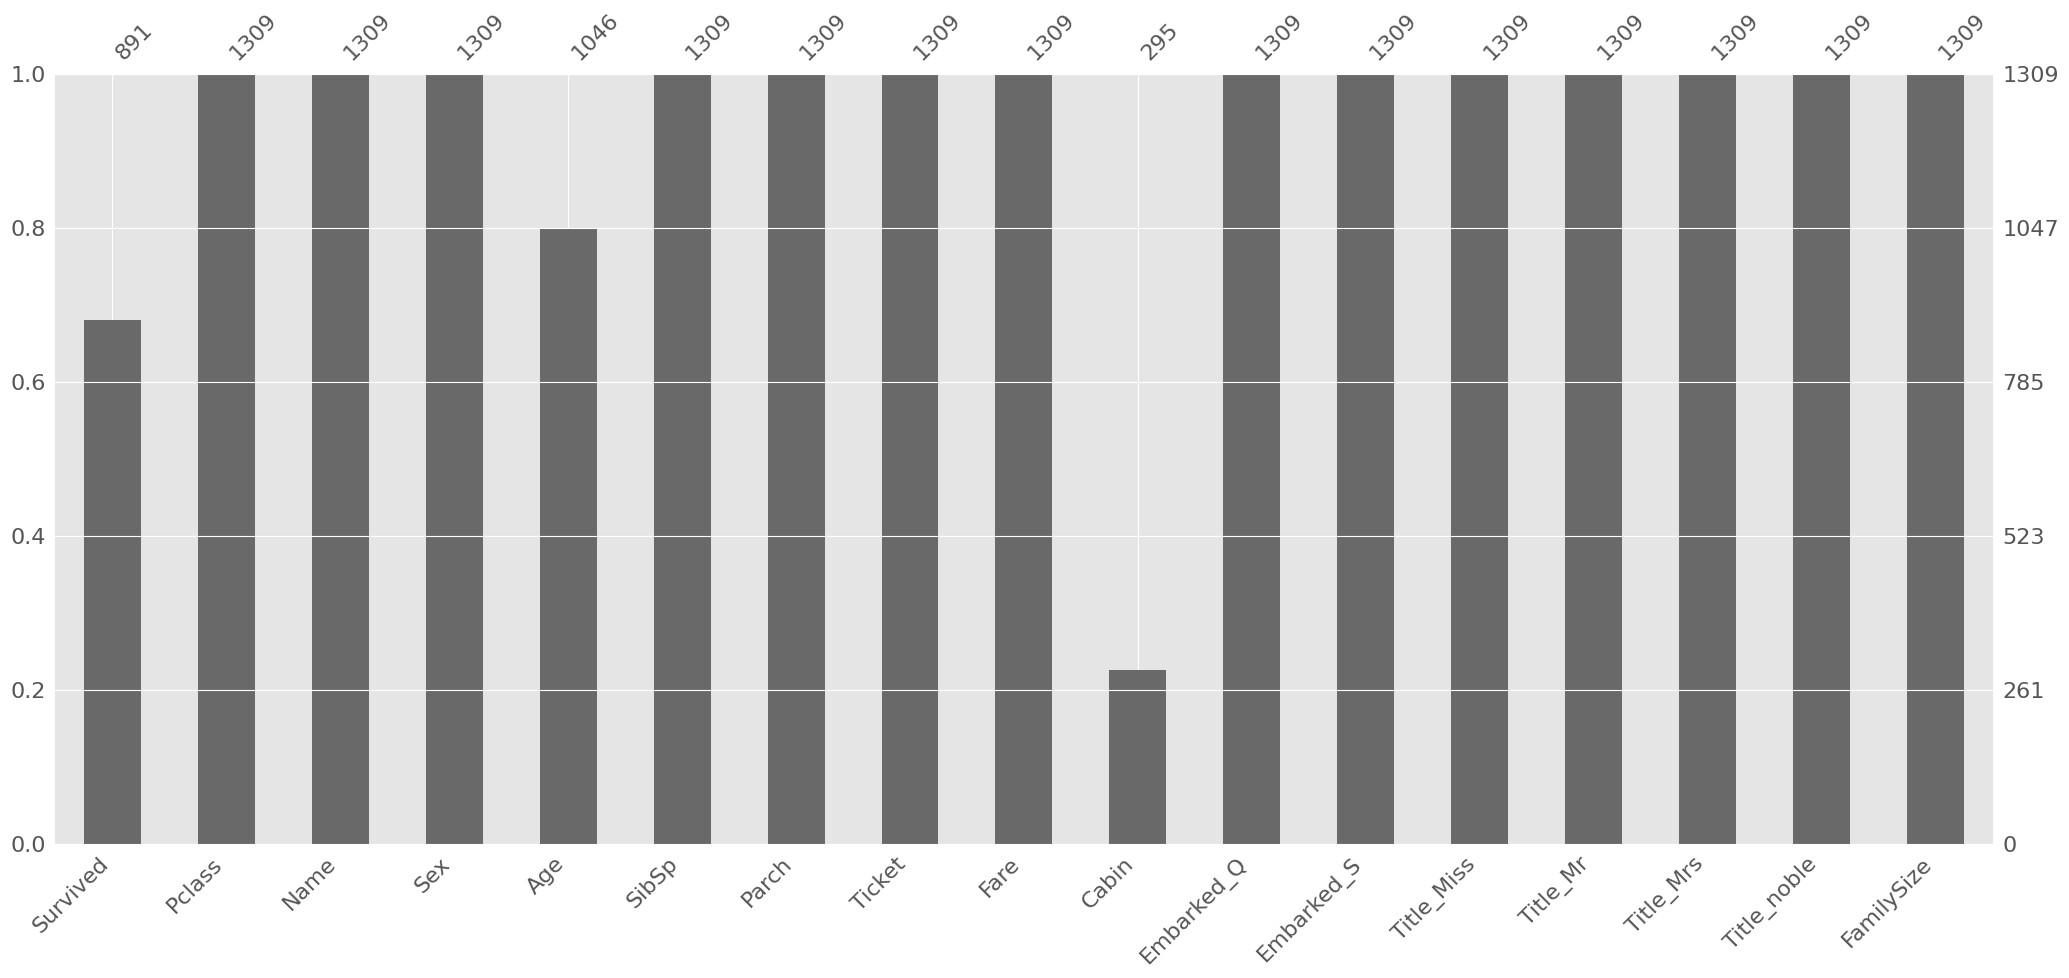

In [29]:
msno.bar(df_combi)

For Age we use the IterateImputer. For this it is only allowed to use the information from the train set and omit the information from the survived column. So split them again.

In [119]:
train_df = df_combi[:len(df_train)].drop(columns=["Name", "Ticket", "Cabin"])
test_df = df_combi[len(df_train):].drop(columns=["Name", "Ticket", "Cabin", "Survived"])

In [120]:
scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[["Fare", "FamilySize"]] = scaler.fit_transform(train_df[["Fare", "FamilySize"]])
test_df[["Fare", "FamilySize"]] = scaler.transform(test_df[["Fare", "FamilySize"]])

Now impute the Age with the help of iterative Imputer.

In [121]:
df_age = train_df.drop(columns=["Survived"])

In [122]:
iter_imp = IterativeImputer()
iter_imp.fit(df_age)

IterativeImputer()

In [123]:
cols = iter_imp.get_feature_names_out()

In [124]:
train_df = pd.DataFrame(iter_imp.transform(df_age), columns = cols)
test_df  = pd.DataFrame(iter_imp.transform(test_df), columns = cols)
age = train_df[["Age"]]
age_test = test_df[["Age"]]

<AxesSubplot: >

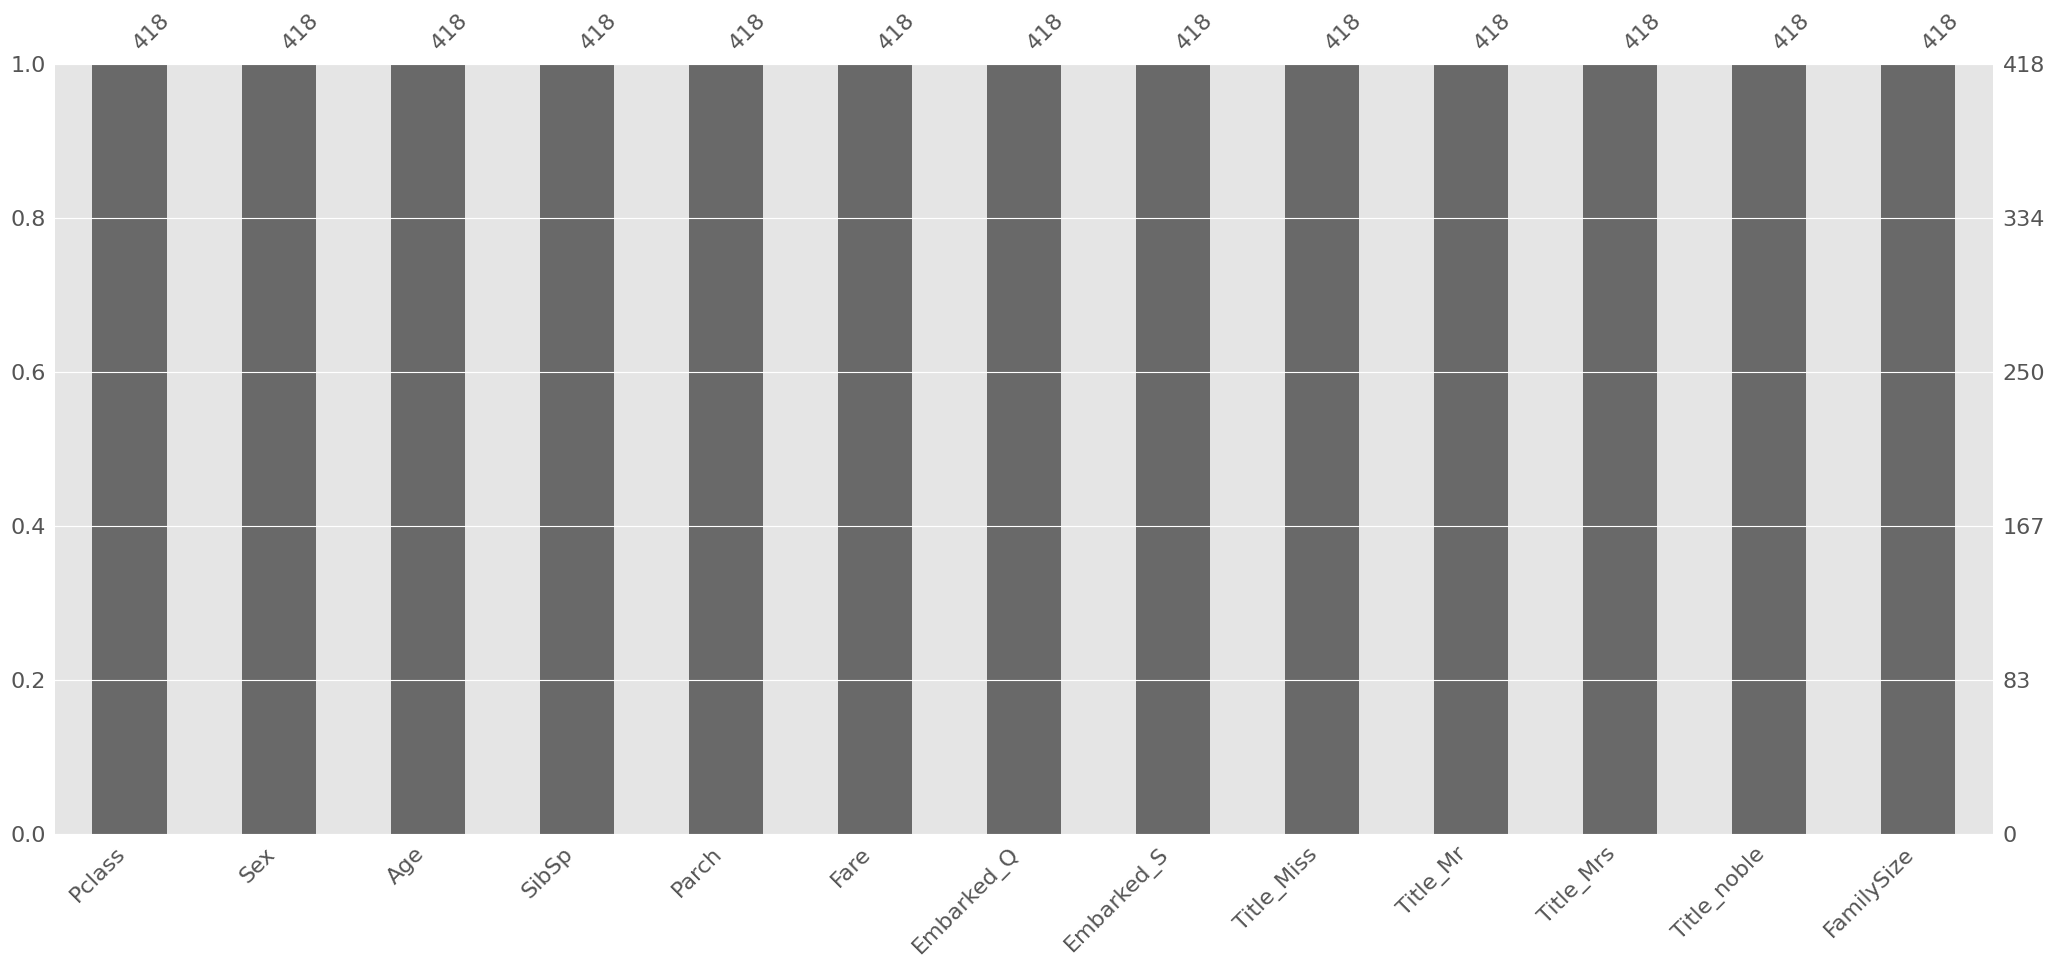

In [125]:
msno.bar(test_df)

### Scale the data

In [126]:
scaler = MinMaxScaler()
train_df[["Age"]] = scaler.fit_transform(train_df[["Age"]])
test_df[["Age"]] = scaler.transform(test_df[["Age"]])

In [127]:
train_df.dtypes

Pclass         float64
Sex            float64
Age            float64
SibSp          float64
Parch          float64
Fare           float64
Embarked_Q     float64
Embarked_S     float64
Title_Miss     float64
Title_Mr       float64
Title_Mrs      float64
Title_noble    float64
FamilySize     float64
dtype: object

### Binning of the data

In that time with the age of 14 and below, one was considered as a child. Introduce new feature child and new feature old (older than 60)

In [128]:
train_df["Child"] = (age<15).astype(int)
test_df["Child"] = (age_test<15).astype(int)

train_df["Elder"] = (age>59).astype(int)
test_df["Elder"] = (age_test>59).astype(int)

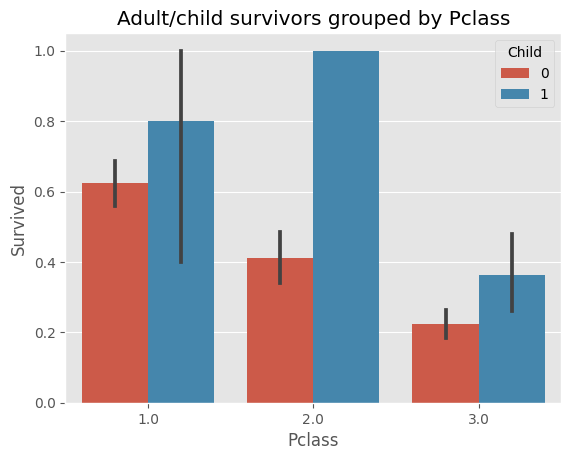

In [129]:
train_df["Survived"] = df_train["Survived"]
sns.barplot(x='Pclass',y='Survived', hue='Child', data=train_df)
plt.title('Adult/child survivors grouped by Pclass')
plt.show()
plt.close()

To be a child is a good indicator for surviving!

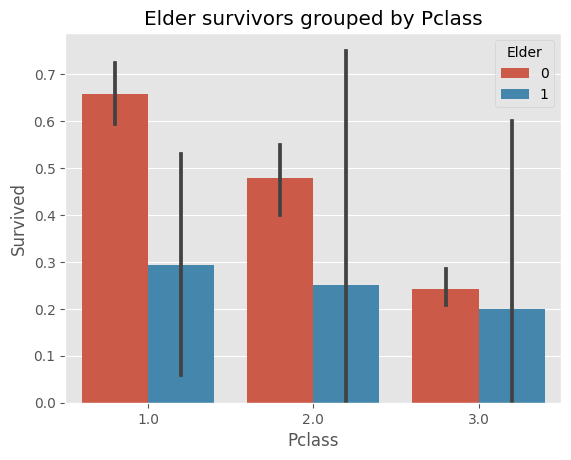

In [130]:
sns.barplot(x='Pclass',y='Survived', hue='Elder', data=train_df)
plt.title('Elder survivors grouped by Pclass')
plt.show()
plt.close()

In [131]:
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

In [132]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [133]:
pipeline = Pipeline([
    ('classifier', GradientBoostingClassifier())
])

param_grid = {
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__max_depth': [3, 4, 5],
    'classifier__n_estimators': [100, 200, 300]
}

In [134]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.1, 0.2, 0.3],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [100, 200, 300]})

In [135]:
grid_search.score(X, y)

0.9349046015712682

In [136]:
y_pred = grid_search.predict(test_df)

In [137]:
print(cross_val_score(grid_search, X, y, cv=3))

[0.8047138  0.83501684 0.82828283]


In [138]:
submission_df = pd.DataFrame({'PassengerId': PassengerId, 'Survived': y_pred})
submission_df.to_csv('submission.csv', index=False)

In [139]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

## Train some models

In [140]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [141]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(Xtrain, ytrain)
dumm_pred = dummy_clf.predict(Xtest)

In [142]:
best = SelectKBest(chi2, k=10)
X_new = best.fit_transform(Xtrain, ytrain)
Xt_new = best.transform(Xtest)

In [206]:
logreg = LogisticRegression(C=1)  #class_weight='balanced'
logreg.fit(X_new, ytrain);
print(logreg.score(X_new, ytrain))
print(logreg.score(Xt_new, ytest))

0.7949101796407185
0.8251121076233184


In [207]:
m = RFECV(xgb.XGBClassifier(), scoring="accuracy")
m.fit(Xtrain, ytrain)

RFECV(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...),
      scoring='accuracy')

In [208]:
print(m.score(Xtrain, ytrain))

0.9700598802395209


In [209]:
print(m.score(Xtest, ytest))

0.7937219730941704


In [210]:
rf = RandomForestClassifier(n_estimators=100, max_depth=100, max_features=2, random_state=42) 
rf.fit(X_new, ytrain)
#plt.barh(X_train.columns, rf.feature_importances_)

RandomForestClassifier(max_depth=100, max_features=2, random_state=42)

In [211]:
df_train["Survived"].isna()

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Name: Survived, Length: 891, dtype: bool

In [212]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_new, ytrain)
#plt.barh(X_train.columns, xgbc.feature_importances_);

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [213]:
svc = SVC(C=100, gamma='auto', kernel='rbf')
svc.fit(X_new, ytrain)

SVC(C=100, gamma='auto')

In [214]:
models = [dummy_clf, logreg, rf, xgbc, svc]

def print_scores(models, Xtrain, ytrain, Xtest, ytest):
    for m in models:
        print(type(m).__name__)
        print('Trainscore: ', m.score(Xtrain, ytrain))
        print('Testscore: ', m.score(Xtest, ytest))
        print()
        
print_scores(models, X_new, ytrain, Xt_new, ytest)

DummyClassifier
Trainscore:  0.6092814371257484
Testscore:  0.6367713004484304

LogisticRegression
Trainscore:  0.7949101796407185
Testscore:  0.8251121076233184

RandomForestClassifier
Trainscore:  0.9326347305389222
Testscore:  0.7982062780269058

XGBClassifier
Trainscore:  0.9296407185628742
Testscore:  0.8161434977578476

SVC
Trainscore:  0.8383233532934131
Testscore:  0.8251121076233184



In [215]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100],
              'class_weight':['balanced',None],
              'max_iter':[500]}

grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3,n_jobs=-1, cv=5) 

# fitting the model for grid search 
grid.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(Xtest) 

# print classification report 
print(classification_report(ytest, grid_predictions)) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'C': 1, 'class_weight': None, 'max_iter': 500}
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       142
           1       0.81      0.75      0.78        81

    accuracy                           0.85       223
   macro avg       0.84      0.83      0.83       223
weighted avg       0.85      0.85      0.85       223



In [216]:
# defining parameter range 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 50, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1) 

# fitting the model for grid search 
grid.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(Xtest) 

# print classification report 
print(classification_report(ytest, grid_predictions)) 

Fitting 5 folds for each of 162 candidates, totalling 810 fits
{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       142
           1       0.84      0.73      0.78        81

    accuracy                           0.85       223
   macro avg       0.85      0.83      0.83       223
weighted avg       0.85      0.85      0.85       223



In [156]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1, cv=5) 

# fitting the model for grid search 
grid.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(Xtest) 

# print classification report 
print(classification_report(ytest, grid_predictions)) 

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'C': 100, 'gamma': 'auto', 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       142
           1       0.85      0.68      0.75        81

    accuracy                           0.84       223
   macro avg       0.84      0.80      0.82       223
weighted avg       0.84      0.84      0.83       223



## Calculate Test score

In [197]:
def print_score(X, y, models):
    if type(models)!=list:
        models = [models]
    for m in models:
        y_pred = m.predict(X)
        print('\033[1m' + 'The Score for the model: ' + '\033[0m', type(m).__name__ , '\n')
        print('accuracy: ', accuracy_score(y, y_pred))
        print(classification_report(y, y_pred, target_names=['Died', 'Survived'], zero_division=1))

        cm = confusion_matrix(y, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()
        plt.close()

The Score for the model:  DummyClassifier 

accuracy:  0.6367713004484304
              precision    recall  f1-score   support

        Died       0.64      1.00      0.78       142
    Survived       1.00      0.00      0.00        81

    accuracy                           0.64       223
   macro avg       0.82      0.50      0.39       223
weighted avg       0.77      0.64      0.50       223



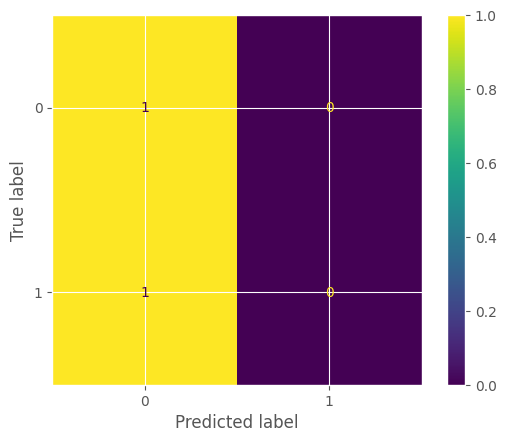

The Score for the model:  LogisticRegression 

accuracy:  0.8565022421524664
              precision    recall  f1-score   support

        Died       0.88      0.90      0.89       142
    Survived       0.82      0.78      0.80        81

    accuracy                           0.86       223
   macro avg       0.85      0.84      0.84       223
weighted avg       0.86      0.86      0.86       223



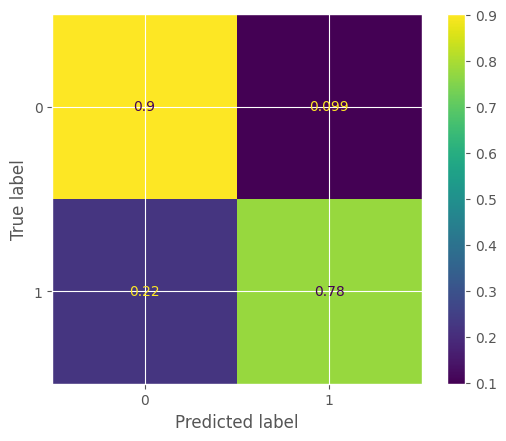

/Users/palex/miniforge3/envs/titanic/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 15 features, but RandomForestClassifier is expecting 10 features as input.

In [198]:
models = [dummy_clf, logreg, rf, xgbc]

print_score(Xtest, ytest, models)

In [162]:
def plot_roc_pr_curve(X, y, models):
    """
        PARAMETERS:
        
        X   :   Dataframe X
        y   :   Target values
        m   :   list of models
    """
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    if type(models)!=list:
        models = [models]
    
    fig, (ax, bx) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=100)
    ax.set_aspect(1)
    bx.set_aspect(1)
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    text = "AUC: \n"
    
    for m in models:
        name = type(m).__name__
        y_proba = m.predict_proba(X)[:, 1]

        # calculate metrics
        auc = roc_auc_score(y, y_proba)
        fpr, tpr, roc_thr = roc_curve(y, y_proba)
        precision, recall, pr_thr = precision_recall_curve(y, y_proba)
        
        text +=  name + ": " + str(np.round(auc, 3)) + "\n"
        
        a_id = find_nearest(roc_thr, 0.5)
        b_id = find_nearest(pr_thr, 0.5)

        ta_x, ta_y = (fpr[a_id], tpr[a_id])
        tb_x, tb_y = (precision[b_id], recall[b_id])

        ### ROC Curve
        ax.plot(fpr, tpr, marker=".", label=name)
        bx.plot(recall, precision, marker='.')
    
    ax.text(0.65, 0.1, text[:-1], ha="center", va="center", size=13, bbox=bbox_props)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title("ROC Curve")
    bx.set_title("Precision-Recall Curve")
    bx.set_xlabel('Recall')
    bx.set_ylabel('Precision')
    fig.legend()

/Users/palex/miniforge3/envs/titanic/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: X has 15 features, but LogisticRegression is expecting 10 features as input.

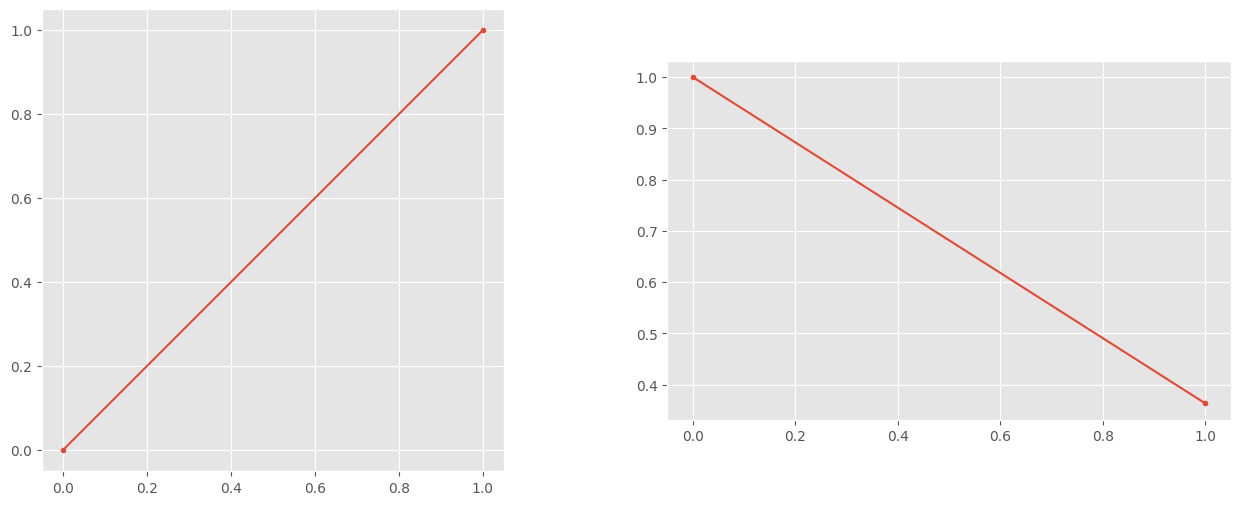

In [163]:
plot_roc_pr_curve(Xtest, ytest, models)

# Kaggle submission

In [164]:
Xtrain.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_noble,FamilySize,Child,Elder
72,2.0,0.0,0.341571,0.0,0.0,0.143462,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0
525,3.0,0.0,0.559187,0.0,0.0,0.015127,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
272,2.0,1.0,0.564767,0.0,1.0,0.038061,0.0,1.0,0.0,0.0,1.0,0.0,0.1,0,0
350,3.0,0.0,0.363890,0.0,0.0,0.018006,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0
531,3.0,0.0,0.413131,0.0,0.0,0.014110,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0


### Try with training on full train data set.

In [165]:
logreg_full = LogisticRegression(C=1, max_iter=1000)
logreg_full.fit(X, y)
logreg_full.score(X, y)

0.8338945005611672

In [166]:
svc_full = SVC(C=100)
svc_full.fit(X, y)
svc_full.score(X, y)

0.8574635241301908

In [167]:
rf_full = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_full.fit(X, y)
rf_full.score(X, y)

0.8383838383838383

In [ ]:
X

In [174]:
xgbc_full = xgb.XGBClassifier()
xgbc_full.fit(X, y)
xgbc_full.score(X, y)

0.9708193041526375

In [175]:
from sklearn.ensemble import StackingClassifier

In [181]:
estimators = [('logreg', LogisticRegression(C=1, max_iter=1000)),
              ('svc', SVC(C=100)),
              ('rf', RandomForestClassifier(**{'bootstrap': True, 'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100})),
              ('xgb', xgb.XGBClassifier())]

name, model = "ensemble", StackingClassifier(estimators=estimators,
                final_estimator=LogisticRegression(**{"penalty":"l2","solver": "liblinear","C":0.2,}),)

In [182]:
model.fit(X, y)
model.score(X, y)

0.8978675645342312

In [179]:
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
output.to_csv('submission_full.csv', index=False)
print("Your submission was successfully saved!")

NameError: name 'X_test' is not defined